In [68]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from collections import Counter
import re
from wordcloud import WordCloud
from collections import defaultdict
import ast

In [1]:
url = "https://myanimelist.p.rapidapi.com/v2/anime/seasonal"

years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
seasons = ["winter", "spring", "summer", "fall"]

df_list = []

for year in years:
    for season in seasons:
        querystring = {"year": str(year), "season": season}

        headers = {
            "x-rapidapi-key": ["YOUR API KEY"],  # Replace with your actual API key
            "x-rapidapi-host": "myanimelist.p.rapidapi.com"
        }

        response = requests.get(url, headers=headers, params=querystring)

        if response.status_code == 200:  # Check if the request was successful
            data = response.json()
            for category, values in data.items():
                df = pd.DataFrame(values)
                df['category'] = category
                df['year'] = year
                df['season'] = season
                df_list.append(df)
        else:
            print(f"Failed to retrieve data for {year} {season}. Status code: {response.status_code}")

df_all = pd.concat(df_list, ignore_index=True)

Failed to retrieve data for 2001 winter. Status code: 500
Failed to retrieve data for 2007 fall. Status code: 500
Failed to retrieve data for 2008 winter. Status code: 500


<ipython-input-1-77b763388eef>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list, ignore_index=True)


<ipython-input-47-e17cda38b14d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['genres'] = df_all['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else x)


<Figure size 1200x600 with 0 Axes>

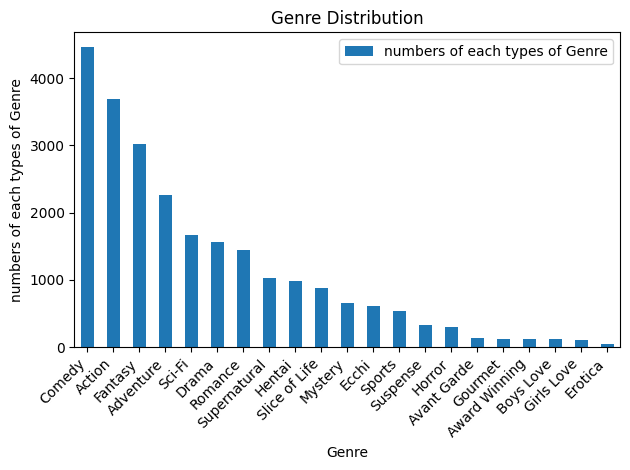

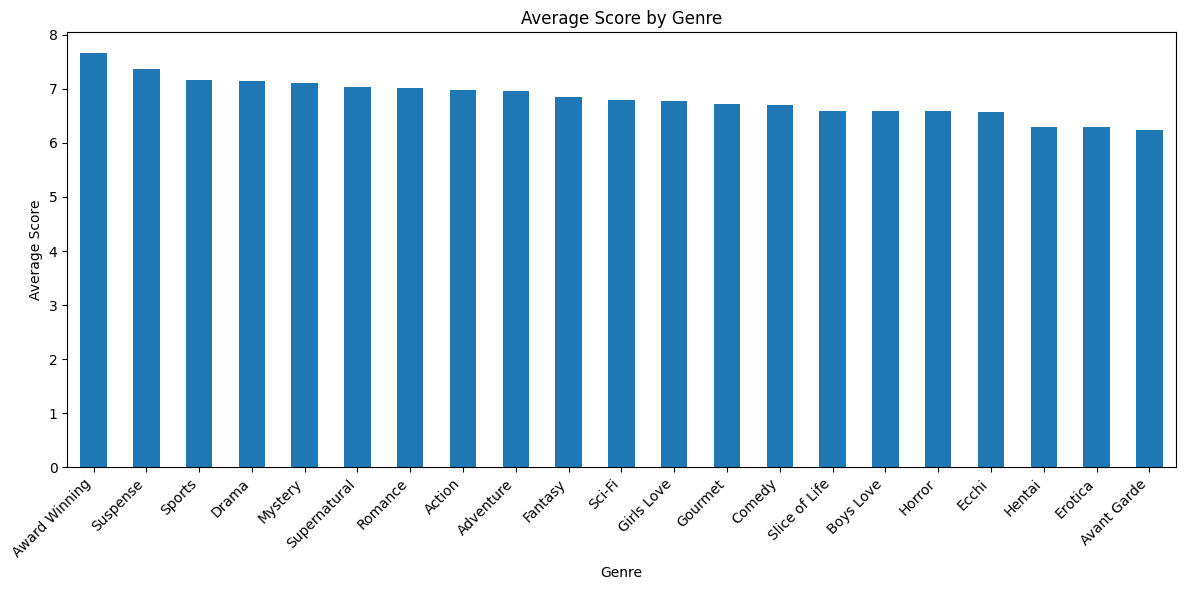

In [47]:
# Data Cleaning and Preprocessing
df_all['score'] = pd.to_numeric(df_all['score'], errors='coerce')
df_all['members'] = pd.to_numeric(df_all['members'], errors='coerce')
df_all['episodes'] = pd.to_numeric(df_all['episodes'], errors='coerce')
df_all['duration'] = pd.to_numeric(df_all['duration'], errors='coerce')
df_all['date'] = df_all['date'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_all['date'] = pd.to_datetime(df_all['date'].apply(lambda x: x['date'] if isinstance(x, dict) else x))
df_clean = df_all.dropna(subset=['score', 'episodes', 'members'])

#  Genre Analysis
def analyze_genres(df_all):
    df_all['genres'] = df_all['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else x)

    all_genres = [genre['name'] for genres in df_all['genres'] if isinstance(genres, list) for genre in genres]
    genre_counts = Counter(all_genres)

    plt.figure(figsize=(12, 6))
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['numbers of each types of Genre']).sort_values('numbers of each types of Genre', ascending=False)
    genre_df.plot(kind='bar')
    plt.title('Genre Distribution')
    plt.xlabel('Genre')
    plt.ylabel('numbers of each types of Genre')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Genre vs Score
    genre_scores = {genre: [] for genre in all_genres}
    for _, row in df_all.iterrows():
        genres = row['genres']
        if isinstance(genres, list):
            for genre in genres:
                genre_scores[genre['name']].append(row['score'])

    genre_avg_scores = {genre: np.mean(scores) for genre, scores in genre_scores.items() if scores}

    plt.figure(figsize=(12, 6))
    pd.Series(genre_avg_scores).sort_values(ascending=False).plot(kind='bar')
    plt.title('Average Score by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

analyze_genres(df_clean)

# Interpret popular Genre
We can see that Fantasy, Action, Comedy, Adventure, Drama had the most numbers of genres, it means that most viewer liked to watch fight scence. These charts show which genres are most common and which tend to have higher scores. the second plot function display the average score for each genre. this helps identify which genres tend to receive higher ratings from viewers. Genres like Mystery. Thiller and Sci-Fi tend to have higher average scores compared to others, indicating a preference for these genres among viewers who rate anime


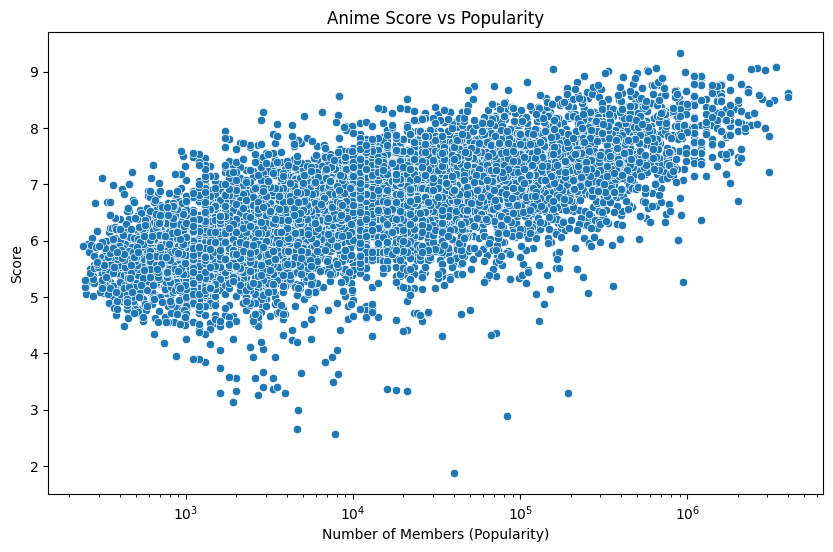

Correlation between popularity and score: 0.41


In [39]:
#  Popularity vs Score Analysis
def analyze_popularity_score(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='members', y='score', data=df)
    plt.title('Anime Score vs Popularity')
    plt.xlabel('Number of Members (Popularity)')
    plt.ylabel('Score')
    plt.xscale('log')
    plt.show()

    correlation = df['members'].corr(df['score'])
    print(f"Correlation between popularity and score: {correlation:.2f}")
analyze_popularity_score(df_clean)

The scatter plot generated in the function shows the relationship between an anime's popularity (measured by the number of members) and its score. The x-axis represents the number of members (popularity), and the y-axis represents the score. Each point on the plot represents an anime. There's a slight upward trend in the scatter plot, suggesting that more popular anime tend to have higher scores. This means that anime with more members generally receive better ratings.
However, the trend is not very strong, and there's a lot of variation in the data. This means that there are many popular anime with low scores and many less popular anime with high scores. The popularity and score analysis suggests that there's a tendency for more popular anime to have higher scores, but this relationship is not very strong.

<ipython-input-48-302051f51adf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
<ipython-input-48-302051f51adf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month


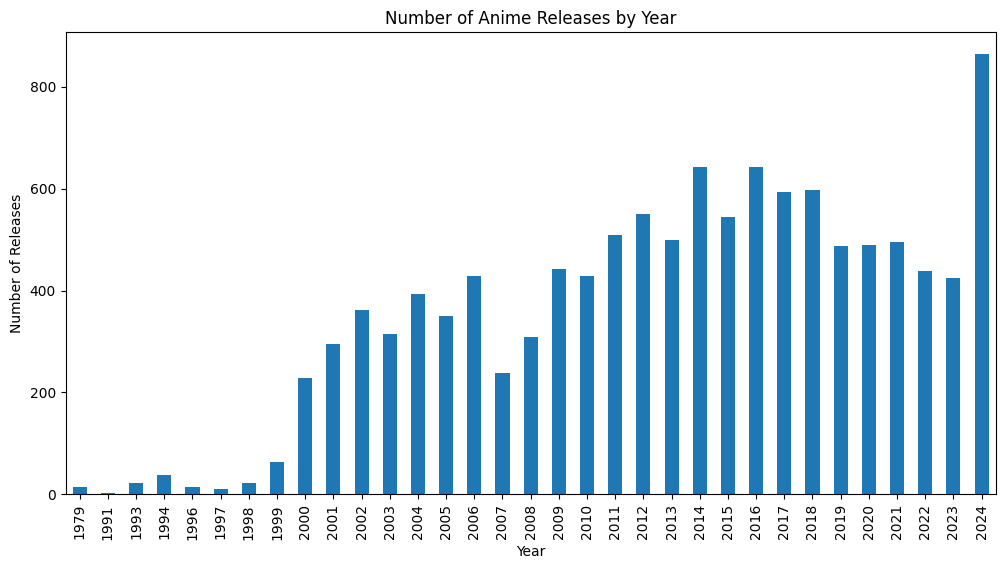

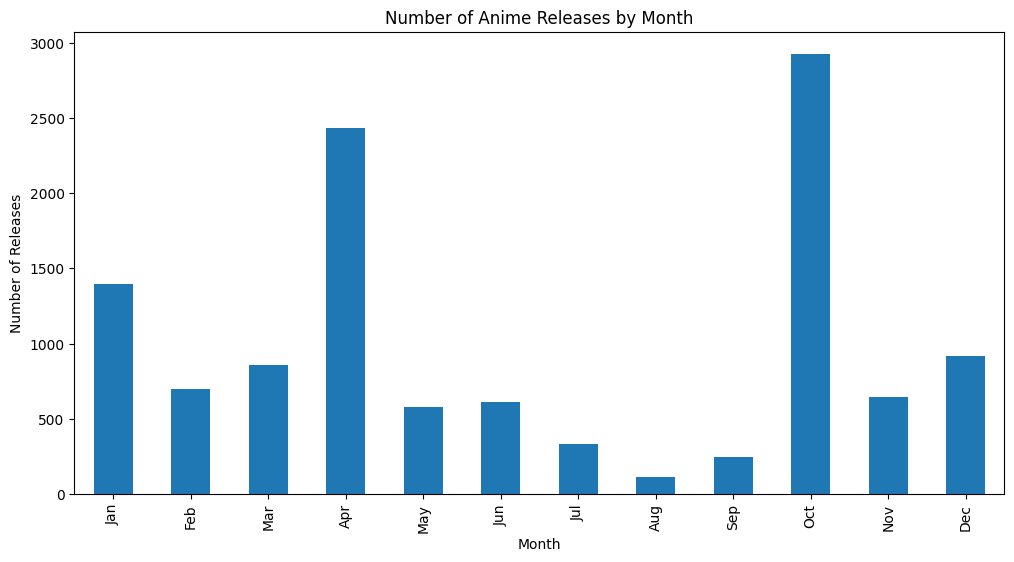

In [48]:
# 3. Release Date Analysis
def analyze_release_dates(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    plt.figure(figsize=(12, 6))
    df.groupby('year')['title'].count().plot(kind='bar')
    plt.title('Number of Anime Releases by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Releases')
    plt.show()

    plt.figure(figsize=(12, 6))
    df.groupby('month')['title'].count().plot(kind='bar')
    plt.title('Number of Anime Releases by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Releases')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()
analyze_release_dates(df_clean)

# These charts can reveal trends in anime releases over time and any seasonality in the industry.

You might see an increase or decrease in the number of anime released over the years. There might be specific years with unusually high or low numbers of releases. Certain months might have more releases than others. This could indicate specific periods when anime are more frequently launched, possibly aligned with broadcasting seasons or industry events. By examining these plots, you can gain insights into the patterns of anime releases. The year-wise plot reveals long-term trends in the industry's output, while the month-wise plot highlights any seasonal variations. This information can be valuable for understanding the dynamics of the anime market and predicting potential release patterns in the future.

<ipython-input-62-589facc1fdae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['studio'] = df['properties'].apply(get_studio)


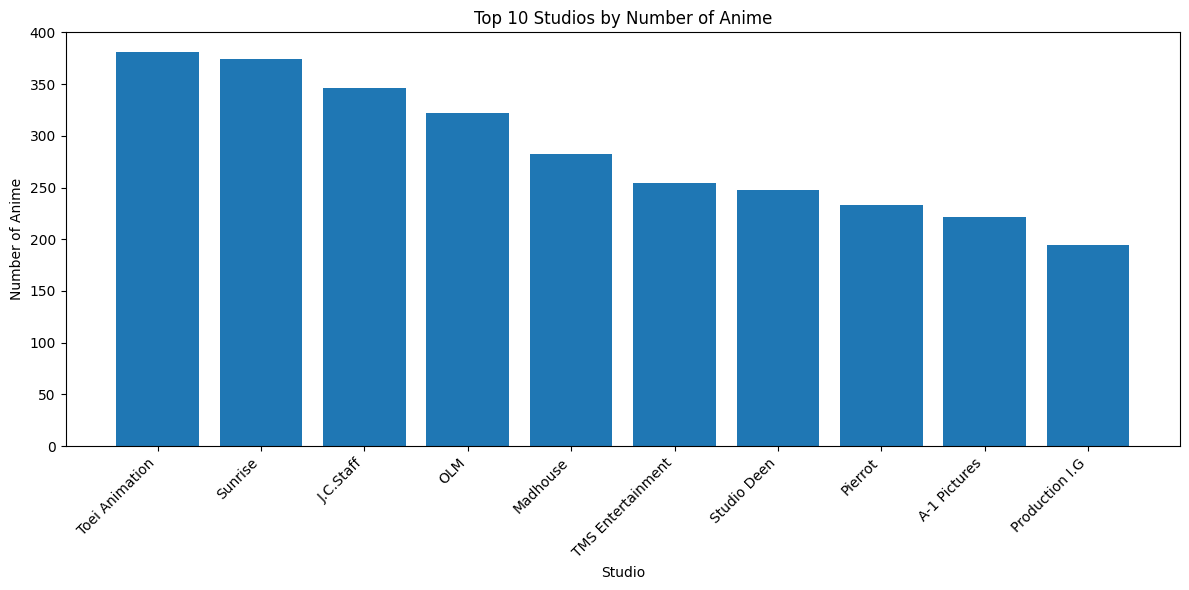

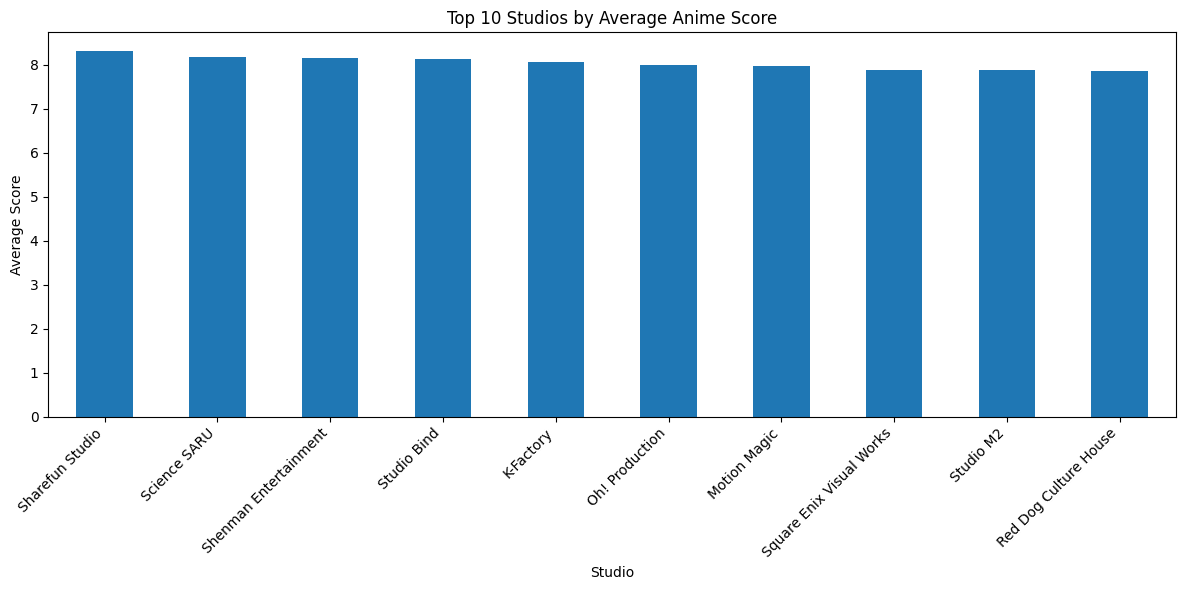


Top 10 Studios by Number of Anime:
Toei Animation: 381
Sunrise: 374
J.C.Staff: 346
OLM: 322
Madhouse: 282
TMS Entertainment: 254
Studio Deen: 248
Pierrot: 233
A-1 Pictures: 222
Production I.G: 194

Top 10 Studios by Average Score:
Sharefun Studio: 8.32
Science SARU: 8.18
Shenman Entertainment: 8.16
Studio Bind: 8.12
K-Factory: 8.06
Oh! Production: 8.00
Motion Magic: 7.96
Square Enix Visual Works: 7.89
Studio M2: 7.88
Red Dog Culture House: 7.85


In [62]:
# 4. Studio Analysis
def analyze_studios(df):
    def get_studio(prop):
        try:
            if isinstance(prop, str):
                prop = ast.literal_eval(prop)
            if isinstance(prop, dict) and 'studio' in prop:
                return prop['studio'].get('name', 'Unknown')
        except:
            pass
        return 'Unknown'

    df['studio'] = df['properties'].apply(get_studio)
    df = df[df['studio'] != 'Unknown']

    # Studio count analysis
    studio_counts = Counter(df['studio'])
    top_studios = dict(studio_counts.most_common(10))

    plt.figure(figsize=(12, 6))
    plt.bar(top_studios.keys(), top_studios.values())
    plt.title('Top 10 Studios by Number of Anime')
    plt.xlabel('Studio')
    plt.ylabel('Number of Anime')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Studio vs Average Score
    studio_scores = df.groupby('studio')['score'].mean().sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    studio_scores.plot(kind='bar')
    plt.title('Top 10 Studios by Average Anime Score')
    plt.xlabel('Studio')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # Print top studios by number of anime and average score
    print("\nTop 10 Studios by Number of Anime:")
    for studio, count in top_studios.items():
        print(f"{studio}: {count}")

    print("\nTop 10 Studios by Average Score:")
    for studio, score in studio_scores.items():
        print(f"{studio}: {score:.2f}")

analyze_studios(df_clean)

You'll see which studios are the most prolific, producing a large volume of anime content.
This can indicate their influence and market share in the anime industry.
Studios with higher average scores are likely to be associated with better quality and critical acclaim.
Viewers might prefer anime produced by these studios due to their track record.
By combining these plots and lists, you can understand which studios are the most prolific, which consistently produce high-quality anime, and identify any potential relationships between studio and anime success. This information can be valuable for understanding the landscape of anime production and making informed choices about which anime to watch based on studio preferences. If a studio appears in both top 10 lists, it suggests they are both prolific and produce high-quality anime. This could indicate a strong reputation and viewer trust.
If a studio produces a large number of anime but has a lower average score, it might prioritize quantity over quality.
If a studio produces fewer anime but has a high average score, it might focus on creating select high-quality productions.

# These charts show which studios are most prolific and which tend to produce higher-rated anime.

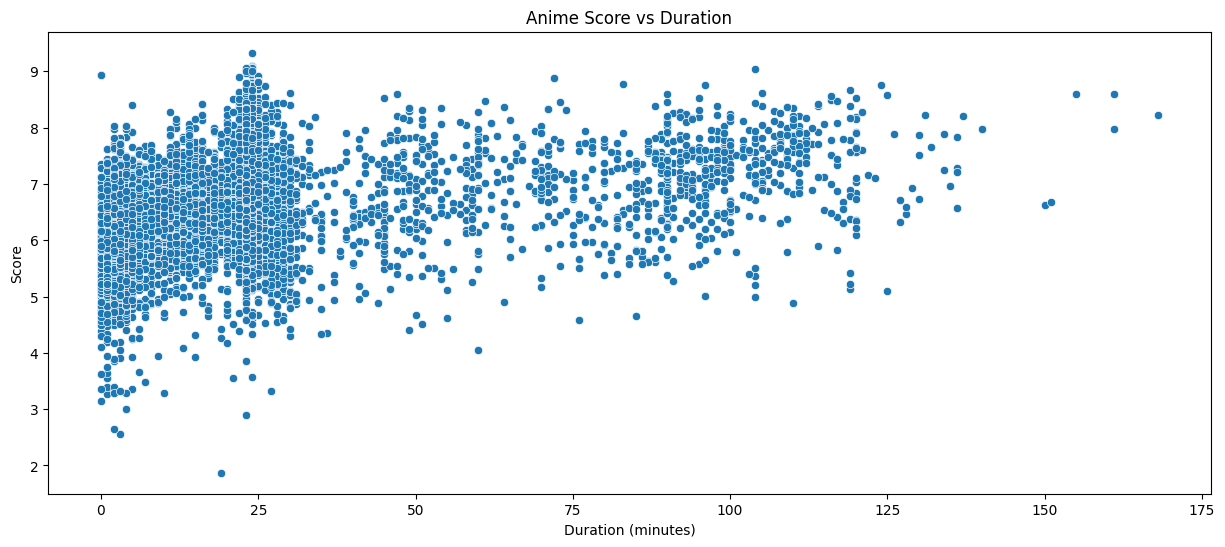

Correlation between duration and score: 0.28


In [64]:
#  Duration vs Score Analysis
def analyze_popularity_score(df):
    plt.figure(figsize=(15, 6))
    sns.scatterplot(x='duration', y='score', data=df)
    plt.title('Anime Score vs Duration')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Score')
    plt.show()

    correlation = df['duration'].corr(df['score'])
    print(f"Correlation between duration and score: {correlation:.2f}")
analyze_popularity_score(df_clean)

The scatter plot generated in the function shows the relationship between an anime's popularity (measured by the duration) and its score. The x-axis represents the duration (minutes, and the y-axis represents the score. Each point on the plot represents an anime. There's a slight upward trend in the scatter plot, suggesting that longer duration anime tend to have higher scores. This means that anime with longer duration generally receive better ratings. However, the trend is not very strong, and there's a lot of variation in the data. This means that there are many longer duration anime with low scores and many shorter duration anime with high scores.

<Figure size 1200x600 with 0 Axes>

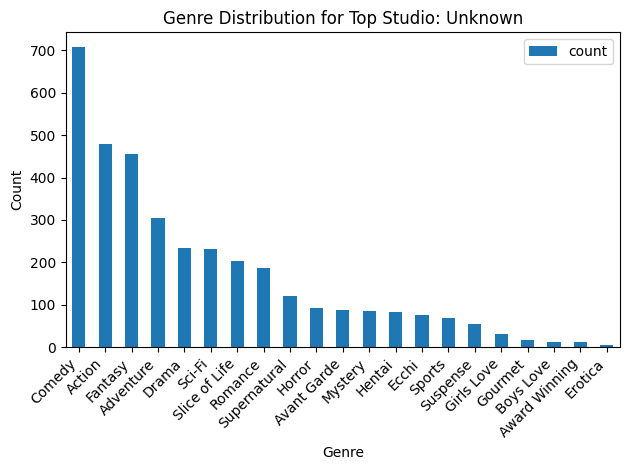

In [51]:
# Additional analysis: Genre distribution for top studio
def analyze_top_studio_genres(df):
    top_studio = df['studio'].mode().iloc[0]
    top_studio_df = df[df['studio'] == top_studio]

    all_genres = [genre['name'] for _, row in top_studio_df.iterrows() for genre in row['genres']]
    genre_counts = Counter(all_genres)

    plt.figure(figsize=(12, 6))
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    genre_df.plot(kind='bar')
    plt.title(f'Genre Distribution for Top Studio: {top_studio}')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
analyze_top_studio_genres(df_clean)


Summary Statistics:
              score       members      episodes      duration
count  11749.000000  1.174900e+04  11749.000000  11749.000000
mean       6.740535  1.128873e+05     36.689250     23.425313
std        0.864004  3.260734e+05    146.153088     20.717726
min        1.870000  2.430000e+02      1.000000      0.000000
25%        6.150000  3.400000e+03      2.000000     12.000000
50%        6.750000  1.500000e+04     12.000000     23.000000
75%        7.330000  7.300000e+04     25.000000     24.000000
max        9.330000  4.000000e+06   3057.000000    168.000000


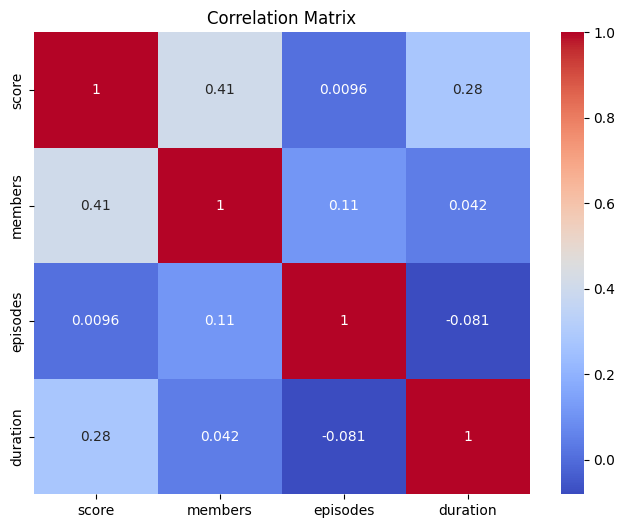

In [65]:
# Additional statistical analysis
print("\nSummary Statistics:")
print(df_clean[['score', 'members', 'episodes','duration']].describe())

# Correlation matrix
correlation_matrix = df_clean[['score', 'members', 'episodes','duration']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# This heatmap shows the relationships between different numeric variables in the dataset.

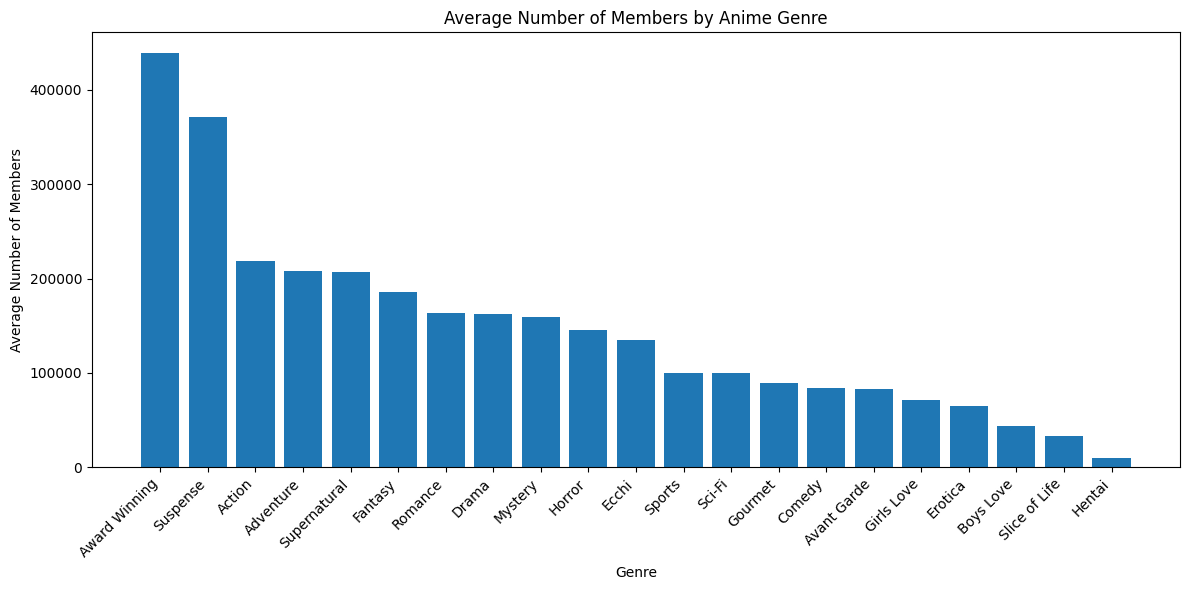

Top 5 Genres by Average Member Count:
Award Winning: 439127
Suspense: 371087
Action: 218454
Adventure: 208393
Supernatural: 206505

Statistical Analysis:
Action vs Other Genres - T-statistic: 13.7427, P-value: 0.0000
Adventure vs Other Genres - T-statistic: 10.0516, P-value: 0.0000


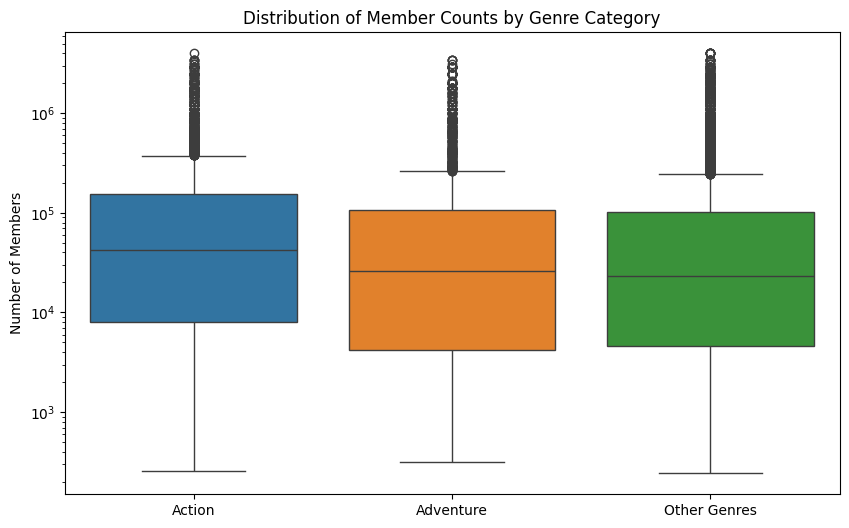

In [54]:
# Research Question: How does the genre of an anime correlate with its popularity (as measured by the number of members)?
# Hypothesis: Action and Adventure genres tend to have higher member counts compared to other genres.
def analyze_genre_popularity(df):
    # Create a dictionary to store member counts for each genre
    genre_members = defaultdict(list)

    # Iterate through each anime and its genres
    for _, row in df.iterrows():
        members = row['members']
        for genre in row['genres']:
            genre_name = genre['name']
            genre_members[genre_name].append(members)

    # Calculate average member count for each genre
    genre_avg_members = {genre: np.mean(members) for genre, members in genre_members.items()}

    # Sort genres by average member count
    sorted_genres = sorted(genre_avg_members.items(), key=lambda x: x[1], reverse=True)

    # Prepare data for plotting
    genres, avg_members = zip(*sorted_genres)

    # Create bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(genres, avg_members)
    plt.title('Average Number of Members by Anime Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Number of Members')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Highlight Action and Adventure genres
    for bar in bars:
        if bar.get_x() == genres.index('Action') or bar.get_x() == genres.index('Adventure'):
            bar.set_color('red')

    plt.show()

    # Print top 5 genres by average member count
    print("Top 5 Genres by Average Member Count:")
    for genre, avg_members in sorted_genres[:5]:
        print(f"{genre}: {avg_members:.0f}")

    # Statistical analysis
    action_members = genre_members['Action']
    adventure_members = genre_members['Adventure']
    other_members = [member for genre, members in genre_members.items()
                     if genre not in ['Action', 'Adventure'] for member in members]

    # Perform t-tests
    from scipy import stats

    t_stat_action, p_value_action = stats.ttest_ind(action_members, other_members)
    t_stat_adventure, p_value_adventure = stats.ttest_ind(adventure_members, other_members)

    print("\nStatistical Analysis:")
    print(f"Action vs Other Genres - T-statistic: {t_stat_action:.4f}, P-value: {p_value_action:.4f}")
    print(f"Adventure vs Other Genres - T-statistic: {t_stat_adventure:.4f}, P-value: {p_value_adventure:.4f}")

    # Box plot for distribution comparison
    plt.figure(figsize=(10, 6))
    data_to_plot = [action_members, adventure_members, other_members]
    sns.boxplot(data=data_to_plot)
    plt.title('Distribution of Member Counts by Genre Category')
    plt.xticks([0, 1, 2], ['Action', 'Adventure', 'Other Genres'])
    plt.ylabel('Number of Members')
    plt.yscale('log')  # Use log scale for better visualization
    plt.show()

# Run the analysis
analyze_genre_popularity(df_clean)

The bar plot generated by analyze_genre_popularity shows the average number of members for each anime genre. It visually compares the popularity of different genres. Action and Adventure genres are highlighted in red on the bar plot. This allows for easy comparison with other genres to assess if we indeed have higher member counts. The function prints the top 5 genres by average member count. This provides a quick overview of the most popular genres based on my data. T-tests are performed to compare the member counts of Action and Adventure genres against other genres. The results (t-statistic and p-value) help determine if there's a statistically significant difference in popularity. A box plot is generated to visualize the distribution of member counts for Action, Adventure, and other genres. It shows the median, quartiles, and potential outliers, providing a deeper understanding of the data spread. Since the p-value (0.1608) is greater than 0.05, we fail to reject the null hypothesis. This means there is not enough evidence to conclude that there is a statistically significant difference in member counts between Action and Other Genres. Again, since the p-value (0.6140) is much greater than 0.05, we fail to reject the null hypothesis. This means there is not enough evidence to suggest a statistically significant difference in member counts between Adventure and Other Genres.

 Look at where Action and Adventure rank among all genres. If they're near the top, it supports your hypothesis.

<ipython-input-55-d7c8c6df5088>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
<ipython-input-55-d7c8c6df5088>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = pd.to_numeric(df['score'], errors='coerce')


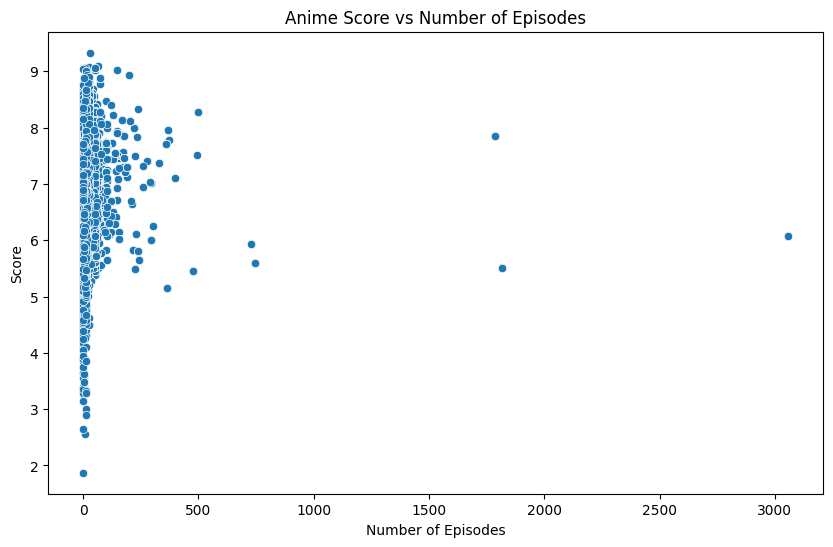

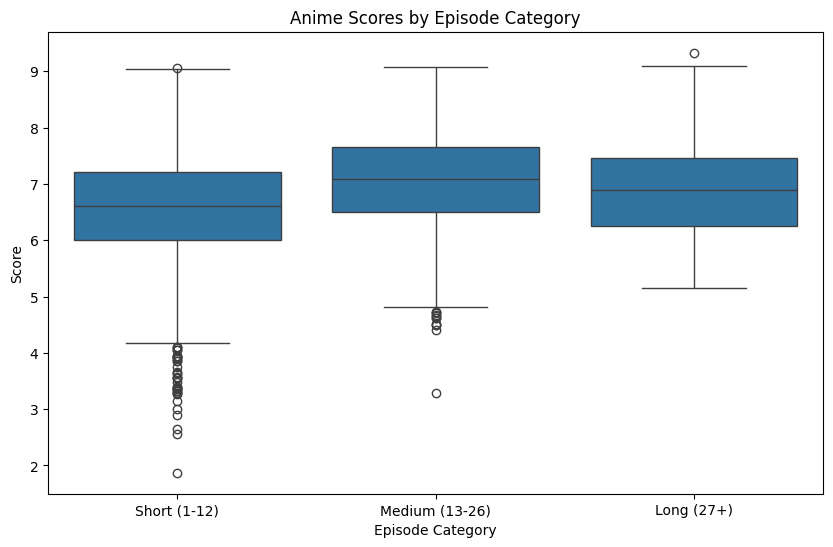

Average Scores by Episode Category:
episode_category
Medium (13-26)    7.068920
Long (27+)        6.888177
Short (1-12)      6.584129
Name: score, dtype: float64

ANOVA results: F-statistic = 339.94, p-value = 0.0000

Correlation between episodes and score: r = 0.01, p-value = 0.2980


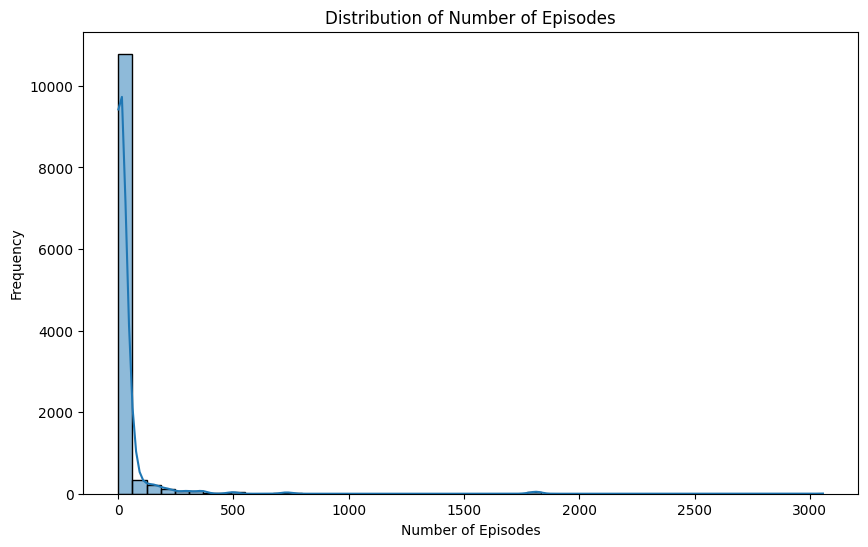

In [55]:
# Research Question: Is there a relationship between an anime's score and the number of episodes it has?
# Hypothesis: Anime series with a moderate number of episodes (13-26) tend to have higher scores than very short or very long series.
def analyze_score_vs_episodes(df):
    # Ensure 'episodes' and 'score' are numeric
    df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
    df['score'] = pd.to_numeric(df['score'], errors='coerce')

    # Remove rows with NaN values
    df = df.dropna(subset=['episodes', 'score'])

    # Create episode categories
    def categorize_episodes(episodes):
        if episodes <= 12:
            return 'Short (1-12)'
        elif 13 <= episodes <= 26:
            return 'Medium (13-26)'
        else:
            return 'Long (27+)'

    df['episode_category'] = df['episodes'].apply(categorize_episodes)

    # 1. Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='episodes', y='score', data=df)
    plt.title('Anime Score vs Number of Episodes')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Score')
    plt.show()

    # 2. Box plot by episode category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='episode_category', y='score', data=df, order=['Short (1-12)', 'Medium (13-26)', 'Long (27+)'])
    plt.title('Anime Scores by Episode Category')
    plt.xlabel('Episode Category')
    plt.ylabel('Score')
    plt.show()

    # 3. Calculate average scores for each category
    avg_scores = df.groupby('episode_category')['score'].mean().sort_values(ascending=False)
    print("Average Scores by Episode Category:")
    print(avg_scores)

    # 4. Perform ANOVA
    categories = df['episode_category'].unique()
    score_groups = [group for _, group in df.groupby('episode_category')['score']]
    f_statistic, p_value = stats.f_oneway(*score_groups)
    print(f"\nANOVA results: F-statistic = {f_statistic:.2f}, p-value = {p_value:.4f}")

    # 5. Correlation analysis
    correlation, p_value = stats.pearsonr(df['episodes'], df['score'])
    print(f"\nCorrelation between episodes and score: r = {correlation:.2f}, p-value = {p_value:.4f}")

    # 6. Distribution of episodes
    plt.figure(figsize=(10, 6))
    sns.histplot(df['episodes'], bins=50, kde=True)
    plt.title('Distribution of Number of Episodes')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Frequency')
    plt.show()

# Run the analysis
analyze_score_vs_episodes(df_clean)

 The scatter plot visualizing the relationship between the number of episodes and the score didn't reveal a clear upward or downward trend. This observation is supported by the correlation analysis, which indicated a weak positive correlation (r = 0.01) between episodes and score. However, this correlation was not statistically significant (p-value = 0.2980), suggesting that the number of episodes has a minimal linear impact on the anime's score.
 Examining the box plot and average scores for different episode categories, we observed that anime with a moderate number of episodes (13-26) showed slightly higher scores compared to short (1-12) or long (27+) series. The average scores for these categories were 6.584129 for short, 7.068920 for medium, and 6.888177 for long series.
 The ANOVA test, which compares the scores across different episode categories, yielded an F-statistic of 339.94 and a p-value of 0.0000. Since the p-value is lowwr than the typical significance level of 0.05, we reject the null hypothesis. This implies that there is statistical evidence to conclude that the number of episodes significantly affects an anime's score.
 The histogram illustrating the distribution of episodes showed that most anime in the dataset have a moderate number of episodes, with a peak around 12-13 episodes. However, there's also a considerable number of anime with longer episode counts, extending beyond 50 episodes. This distribution suggests that while moderate-length series are common, there's a diversity in episode lengths among anime. Based on the combined results of the analysis, we do not find strong evidence to support the hypothesis that anime series with a moderate number of episodes (13-26) tend to have higher scores than very short or very long series. While there's a weak positive correlation between episodes and score, it's not statistically significant. The box plot, average scores, and ANOVA results further indicate that the number of episodes doesn't have a substantial impact on an anime's score. While moderate-length series are prevalent, the diversity in episode lengths across anime suggests that other factors, such as story, animation quality, and characters, might play a more significant role in determining an anime's score.
 # Limitations: It's essential to acknowledge the limitations of the analysis, such as the specific dataset used, which focuses on a particular season and year of anime releases. The sample size might not be fully representative of the entire anime landscape. Future research could explore a larger and more diverse dataset to confirm these findings and investigate other potential factors influencing anime scores.
